# Causal DAGS for Quasi-Experiments

This page provides an overview of causal Directed Acyclic Graphs (DAG's) for some of the most common quasi-experiments. It takes inspiration from a paper by {cite:t}`steiner2017graphical`, and the books by {cite:t}`cunningham2021causal` and {cite:t}`huntington2021effect`, and readers are encouraged to consult these sources for more details.

In [2]:
import daft
import matplotlib.pyplot as plt

In [3]:
ff = "times new roman"
plt.rcParams["font.family"] = ff

GRID_UNIT = 2.0
DPI = 200
NODE_EC = "none"

Before we take a look at randomized controlled trials (RCTs) and quasi-experiments, let's first consider the concept of confounding. Confounding occurs when a variable (or variables) causally influence both the treatment and the outcome and is very common in observational studies. This can lead to biased estimates of the treatment  effect (the causal effect of $Z \rightarrow Y$). The following causal DAG illustrates the concept of confounding. Note that the confounder is written as a vector because there may be multiple confounding variables,  $\mathbf{X}=x_1, x_2,x_3$.

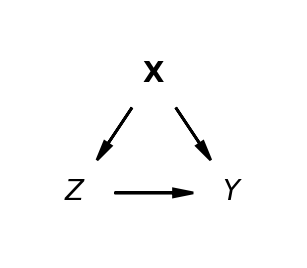

In [3]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_node("y", "$Y$", 2, 0)

pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_edge("x", "z")

pgm.render();

One way to tell that our estimate of the causal relationship $Z \rightarrow Y$ may be biased is the presence of a backdoor path, $Z \leftarrow \mathbf{X} \rightarrow Y$. This path type is known as a "fork". Because $\mathbf{X}$ is a common cause of $Z$ and $Y$, any observed statistical relation between $Z$ and $Y$ may be due to the confounding effect of $\mathbf{X}$. 

Backdoor paths are problematic because they introduce _statistical associations_ between variables that do not reflect the true causal relationships, potentially leading to biased causal estimates. For example, if we ran a regression of the form `y ~ z`, and observe a main effect of $Z$ on $Y$, we have no way of knowing if this represents a true causal impact of $Z$ on $Y$, or if it is due to the confounding effect of $\mathbf{X}$. 

One approach is to "close the backdoor path" by conditioning on the confounding variables. Practically, this could involve including confounders $\mathbf{X}$ as a covariate in a regression model such as: `y ~ z + x₁ + x₂ + x₃`. Without explaining why, the coefficient for the main effect of $Z$ would now be an unbiased estimate of the _causal_ effect of $Z \rightarrow Y$.

However, unless we are very sure that we have accurate measures of _all_ confounding variables (maybe there is an $x_4$ that we don't know about or couldn't measure), it is still possible that our estimate of the causal effect is biased.

This leads us to Randomized Controlled Trials (RCTs) which are considered the gold standard for estimating causal effects. One reason for this is that we (as experimenters) intervene in the system by assigning units to treatment by {term}`random assignment`. Because of this intervention, any causal influence of the confounders upon the treatment $\mathbf{X} \rightarrow Z$ is broken - treamtent is now solely determined by the randomisation process, $R \rightarrow T$. The following causal DAG illustrates the structure of an RCT.

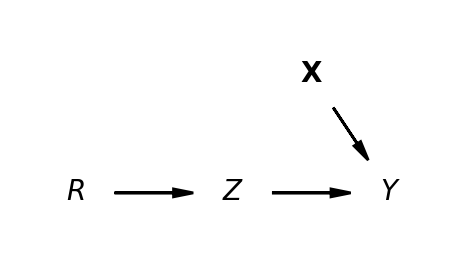

In [4]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("r", "$R$", 0, 0)
pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_node("y", "$Y$", 2, 0)

pgm.add_edge("r", "z")
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")

pgm.render();

The new variable $R$ represents the random assignment of units to the treatment group. This means that the treatment effect $Z \rightarrow Y$ can be estimated without bias.

## Instrumental Variables

In quasi-experiments, we cannot randomly assign subjects to treatment groups. So confounders $\mathbf{X}$ will still influence treatment assignment. In the instrumental variable (IV) approach, the causal effect of $Z \rightarrow Y$ is identifiable if we have an IV that causally influences the treatment $Z$ but not the outcome $Y$.

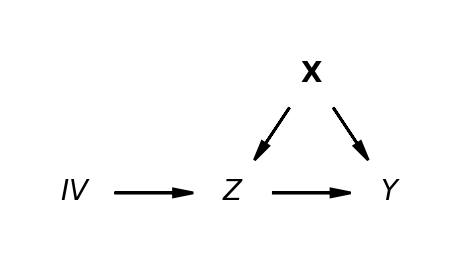

In [5]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("iv", "$IV$", 0, 0)
pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("y", "$Y$", 2, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_edge("iv", "z")
pgm.add_edge("x", "z")
pgm.add_edge("x", "y")
pgm.add_edge("z", "y")

pgm.render();

Let's try to get some intuition of why having the $IV$ helps:
* The presence of $\mathbf{X}$ is a confounder because it influences both $Z$ and $Y$.
* But the $IV$ helps overcome this confounding because it is not influenced by $\mathbf{X}$.
* Any association between the $IV$ and $Y$ must be through the treatment $Z$.
* This means that the $IV$ can be used to estimate the causal effect of $Z \rightarrow Y$, without being confounded by $\mathbf{X}$. Informally, the $IV$ causes some variation in the treatment $Z$ that is not due to $\mathbf{X}$, and this variation can be used to estimate the causal effect of $Z \rightarrow Y$.

Readers are referred to {cite:t}`steiner2017graphical,cunningham2021causal` or {cite:t}`huntington2021effect` for a more in-depth discussion of the IV approach from the causal DAG perspective.

## Interrupted Time Series

A causal DAG for interrupted time series quasi-experiment is given in Chapter 17 of {cite:t}`huntington2021effect`, though they are labelled as [Event Studies](https://theeffectbook.net/ch-EventStudies.html). These kinds of studies are suited to situations where an intervention is made at a given point in time at which we move from untreated to treated. Typically, we consider situations where there are a 'decent' number of observations over time. Here's the causal DAG - note that $\text{time}$ represents all the things changing over time such as the time index as well as time-varying predictor variables.

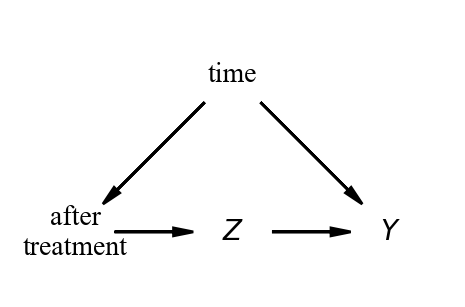

In [6]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("a", "after\ntreatment", -1, 0)
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_node("t", "time", 0, 1)

pgm.add_edge("a", "z")
pgm.add_edge("t", "a")
pgm.add_edge("t", "y")
pgm.add_edge("z", "y")

pgm.render();

What we want to understand is the causal effect of the treatment upon the outcome, $Z \rightarrow Y$. But we have a back door path between $Z$ and $Y$ which will make this hard, $Z \leftarrow \text{after treatment} \leftarrow \text{time} \rightarrow Y$.

:::{note}
Below is an attempt to explain one way that we can deal with this. Though it is a bit of a brain-twister and can take some time to get your head around. Thanks to Nick Huntington-Klein for some clarification in [this twitter thread](https://twitter.com/inferencelab/status/1783882438063661374).
:::

One approach we can use is:
1. We want to close the backdoor path, and one way to do this is to split the dataset into two parts: pre-treatment and post-treatment. By fitting a model only to the pre-treatment data, we have removed any variation in $\text{after treatment}$ (all values are $0$), so there is now no variation in $Z$ caused by $\text{time}$. This is one way to close a backdoor path, and means that a model fitted to this data (e.g. $Y_{\text{pre}} \sim f(\text{time}_{\text{pre}})$) will not be biased by the backdoor path.
2. However, our goal is to estimate the causal effects of the treatment $Z \rightarrow Y$, but we have just removed any variation in $Z$ and it does not appear in the aforementioned model, $Y_{\text{pre}} \sim f(\text{time}_{\text{pre}})$, so our work is not done. One way to deal with this is to use the model to predict what would have happened in the post-treatment era if no treatment had been given. If we make the assumption that nothing would have changed in the absence of treatment, then this will be an unbiased estimate of the counterfactual. By comparing the counterfactual with the observed post-treatment data, we can estimate the treatment effect $Z \rightarrow Y$. By focussing only on the post-treatment data we are looking at empirical outcomes $Y_\text{post}$ which are affected by treatment $Z = 1$, but have closed the back door because all $\text{after treatment} = 1$. The final comparison (subtraction) between the counterfactual estimate and the observed post-treatment data gives us the estimated treatment effect.

## Propensity Score Weighting

In this exposition we follow the presentation of {cite:t}`steiner2017graphical`. The idea they discuss is that we should conceive of the propensity score adjustment techniques as a primarily an offset aimed at balancing the existing degree of confounding. The focus is on recovering the condition of __strong ignorability__ such that $Y(1), Y(0) \perp\!\!\!\!\perp Z | X$. This constraint is phrased in terms of potential outcomes $Y(0), Y(1)$, which we won't define here, but basically we're saying the outcomes are independent of the treatment when we condition on the covariates $X$ which determine selection effects. Achieving this status removes the backdoor path between the measured covariates $X$ and the treatment $Z$ thereby giving us license to causal conclusions. They emphasise this point in that the PS (propensity score) is a collider variable we can use to disentangle the confounding influence of the covariates $X$ influencing selection into the treatment. 

> "This general result is obtained because the PS _itself_ is a collider variable and, thus, conditioning on the PS offsets the confounding relation $X \rightarrow Z$  regardless of the choice of a specific PS design— matching, stratification, or weighting" -pg 176 "Graphical Models
for Quasi-experimental Designs"

However, we have to be wary that the design assumes all relevant variables are measured in $X$, it cannot account for unmeasured confounding. In this way, we try to recover the conditions of an RCT using PS but need to be wary of unmeasured confounding. 


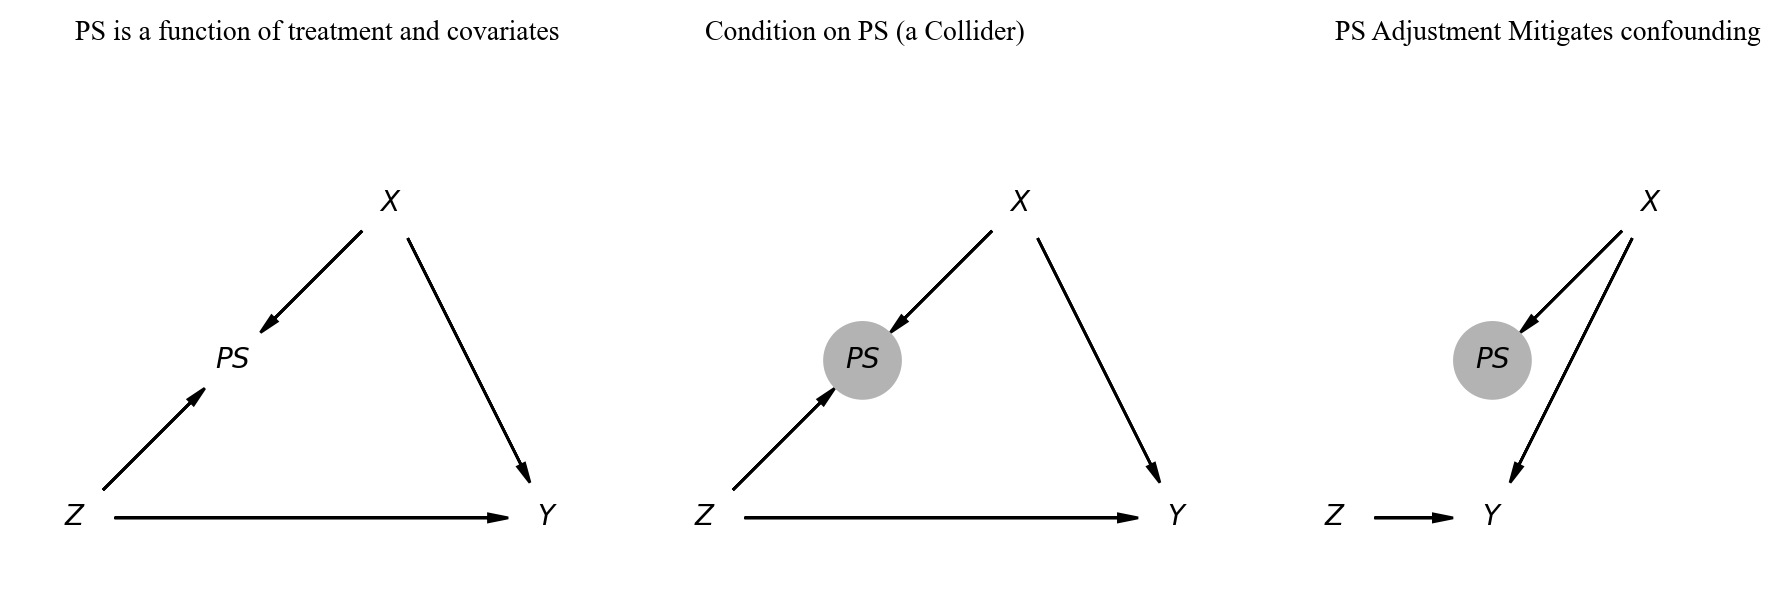

In [36]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 3, 0)
pgm.add_node("x", "$X$", 2, 2)
pgm.add_node("ps", "$PS$", 1, 1)

pgm.add_node("z1", "$Z$", 4, 0)
pgm.add_node("y1", "$Y$", 7, 0)
pgm.add_node("x1", "$X$", 6, 2)
pgm.add_node("ps1", "$PS$", 5, 1, observed=True)

pgm.add_node("z2", "$Z$", 8, 0)
pgm.add_node("y2", "$Y$", 9, 0)
pgm.add_node("x2", "$X$", 10, 2)
pgm.add_node("ps2", "$PS$", 9, 1, observed=True)


pgm.add_edge("x", "ps")
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_edge("z", "ps")

pgm.add_edge("x1", "ps1")
pgm.add_edge("z1", "y1")
pgm.add_edge("x1", "y1")
pgm.add_edge("z1", "ps1")

pgm.add_edge("x2", "ps2")
pgm.add_edge("z2", "y2")
pgm.add_edge("x2", "y2")

pgm.add_text(0, 3, label="PS is a function of treatment and covariates")
pgm.add_text(4, 3, label="Condition on PS (a Collider)")
pgm.add_text(8, 3, label="PS Adjustment Mitigates confounding")

pgm.render();

One nice feature of this set up is that we can evaluate the claim of __strong ignorability__ because it implies that  $Z  \perp\!\!\!\perp  X | PS(X)$ and this ensures the covariate profiles are balanced across the treatment branches conditional on the propensity score. This is a testable implication of the postulated design! Balance plots and measures are ways in which to evaluate if the offset achieved by your propensity score has worked. It is crucial that PS serve as a balancing score, if the measure cannot serve as a balancing score the collision effect can add to the confounding bias rather than remove it. 

## Difference in Differences

Difference in Difference studies involve comparing the change in outcomes over time between a treatment and control group. The causal DAG for this is given in Chapter 18 of {cite:t}`huntington2021effect`:

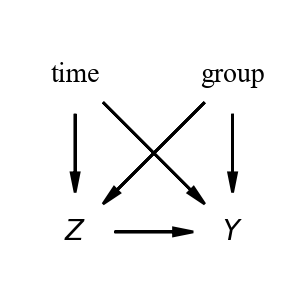

In [8]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_node("t", "time", 0, 1)
pgm.add_node("g", "group", 1, 1)
pgm.add_edge("t", "z")
pgm.add_edge("t", "y")
pgm.add_edge("g", "z")
pgm.add_edge("g", "y")
pgm.add_edge("z", "y")
pgm.render();

:::{note}
For our explanation below, we will assume we are dealing with the simplest case of a two-group, two-time period design, the so called "classical" 2$\times$2 difference-in-differences design. 
:::

Our goal is to estimate the causal effect of the treatment on the outcome, $Z \rightarrow Y$, but now we have _two_ backdoor paths:
1. $Z \leftarrow \text{time} \rightarrow Y$
2. $Z \leftarrow \text{group} \rightarrow Y$

From a regression point of view, both $time$ and $group$ are binary variables. In this situation, treatment is given to the treatment group ($\text{group}=1$) at time $\text{time}=1$.

The causal effect of the treatment upon the outcome is typically estimated by fitting a regression model of the form `y ~ time + group + time:group`. The interaction term `time:group` captures the causal effect of $Z \rightarrow Y$. 

We can note that this interaction term $\text{time} \times \text{group}$ encodes the values of $Z$, which as we said above, is equal to 1 for only the treatment group at time 1. So another way to think about the inclusion of an interaction effect is that we are simply conditioning on all the observed data ($Z$, $\text{time}$, $\text{group}$, $Y$) to estimate the causal effect of $Z \rightarrow Y$.

:::{warning}
Achieving an unbiased estimate is strongly dependent upon the {term}`parallel trends assumption`. That is, we assume that the treatment and control groups would have followed the same trajectory (over time) in the absence of treatment. This is a strong assumption and should be carefully considered when interpreting the results of a difference-in-differences study. In the case of the classic 2$\times$2 design we cannot assess the validity of this assumption empirically, so it is important to consider the plausibility of this assumption in the context of the particular example. 
:::

## Synthetic Control

:::{warning}
While many texts cover the synthetic control method, they typically do not provide a causal DAG-based treatment. So this section is pending - we hope to update it soon.
:::

## Regression Discontinuity
 
The regression discontinuity design is similar to the interrupted time series design, but rather than the the treatment being at a specific point in time, treatment is based on a cutoff value $\lambda$ along some running variable $RV$. This running variable could be a test score, age, spatial location, etc. The running variable may also influence the outcome $RV \rightarrow Y$. The running variable may also be associated with a set of variables $\mathbf{X}$ that influence the outcome, $RV - - - - \mathbf{X} \rightarrow Y$.

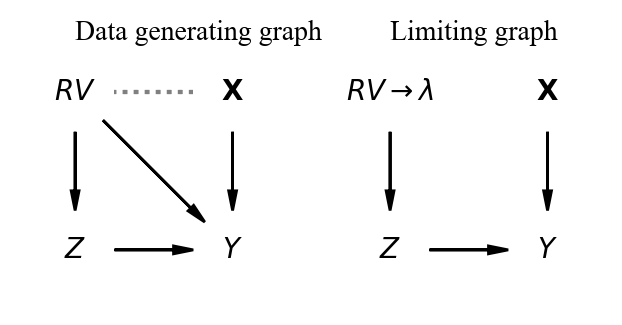

In [12]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

# data generating graph
pgm.add_node("a", "$RV$", 0, 1)
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("x", "$\mathbf{X}$", 1, 1)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_edge("a", "z")
pgm.add_edge("a", "y")
pgm.add_edge(
    "a",
    "x",
    plot_params={"ec": "grey", "lw": 1.5, "ls": ":", "head_length": 0, "head_width": 0},
)
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_text(0, 1.3, "Data generating graph")

# limiting graph
x_offset = 2
pgm.add_node("a2", r"$RV \rightarrow \lambda$", 0 + x_offset, 1)
pgm.add_node("z2", "$Z$", 0 + x_offset, 0)
pgm.add_node("x2", "$\mathbf{X}$", 1 + x_offset, 1)
pgm.add_node("y2", "$Y$", 1 + x_offset, 0)
pgm.add_edge("a2", "z2")
pgm.add_edge("z2", "y2")
pgm.add_edge("x2", "y2")
pgm.add_text(x_offset, 1.3, "Limiting graph")

pgm.render();

We can see from the data generating graph (left) that the $RV$ is a confounding variable as it influences both the treatment $Z$ and the outcome $Y$. 

If we tried to identify the causal effect of $Z \rightarrow Y$ by conditioning on the running variable ($RV=rv$), we would eliminate any variation in $Z$ or $Y$ caused by $RV$. And because $Z$ is constant for any given value of $RV$, then the $Z \rightarrow Y$ path would disappear and we could not estimate the causal effect.

Identification of the causal effect of $Z \rightarrow Y$ is done with a limiting graph (right). The $RV$ node is replaced by a subset of the data where $RV$ is close to the cutoff value $\lambda$, hence the name "limiting graph" and the symbol $RV \rightarrow \lambda$.

In the limit, this eliminates variation in the running variable and so breaks the $RV \rightarrow Y$ path. The causal effect of $Z \rightarrow Y$ can be estimated by comparing the outcomes of units just above and just below the cutoff value $\lambda$.

Readers are referred to {cite:t}`steiner2017graphical` and [Chapter 6](https://mixtape.scunning.com/06-regression_discontinuity) of {cite:t}`cunningham2021causal` who discuss limiting graphs in more detail. Chapter 20 of {cite:t}`huntington2021effect` also covers regression discontinuity designs, but presents simplified (and non-kosher, in his own words) causal DAG.

## References
:::{bibliography}
:filter: docname in docnames
:::